In [2]:
import numpy as np
import pandas as pd
from seaborn import heatmap
from seaborn import pairplot
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
#Import all the data
data = pd.read_csv("archive/movies.csv")
#print(data.columns)

#print(data.info())
data = data.drop(columns = ["name", "rating", "genre", "released", "director", "writer", "star", "country", "company"])
data.dropna(inplace =True)
data["votes"] = data["votes"].apply(lambda x: x / 1000)
data["budget"] = data["budget"].apply(lambda x: x / 1000000)
data["gross"] = data["gross"].apply(lambda x: x / 1000000)
print(data.head())

# Now convert the data into train and test splits
train_data, test_data = train_test_split(data, train_size = 0.8, random_state = 0)
print(data.info())


   year  score   votes  budget       gross  runtime
0  1980    8.4   927.0    19.0   46.998772    146.0
1  1980    5.8    65.0     4.5   58.853106    104.0
2  1980    8.7  1200.0    18.0  538.375067    124.0
3  1980    7.7   221.0     3.5   83.453539     88.0
4  1980    7.3   108.0     6.0   39.846344     98.0
<class 'pandas.core.frame.DataFrame'>
Index: 5435 entries, 0 to 7652
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     5435 non-null   int64  
 1   score    5435 non-null   float64
 2   votes    5435 non-null   float64
 3   budget   5435 non-null   float64
 4   gross    5435 non-null   float64
 5   runtime  5435 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 297.2 KB
None


<Axes: >

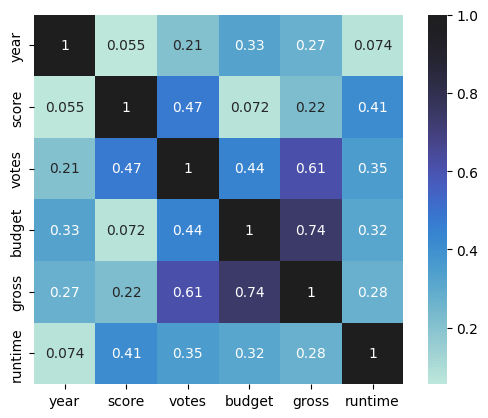

In [4]:
heatmap(data = data.corr(), center = 1, annot = True, square = True)

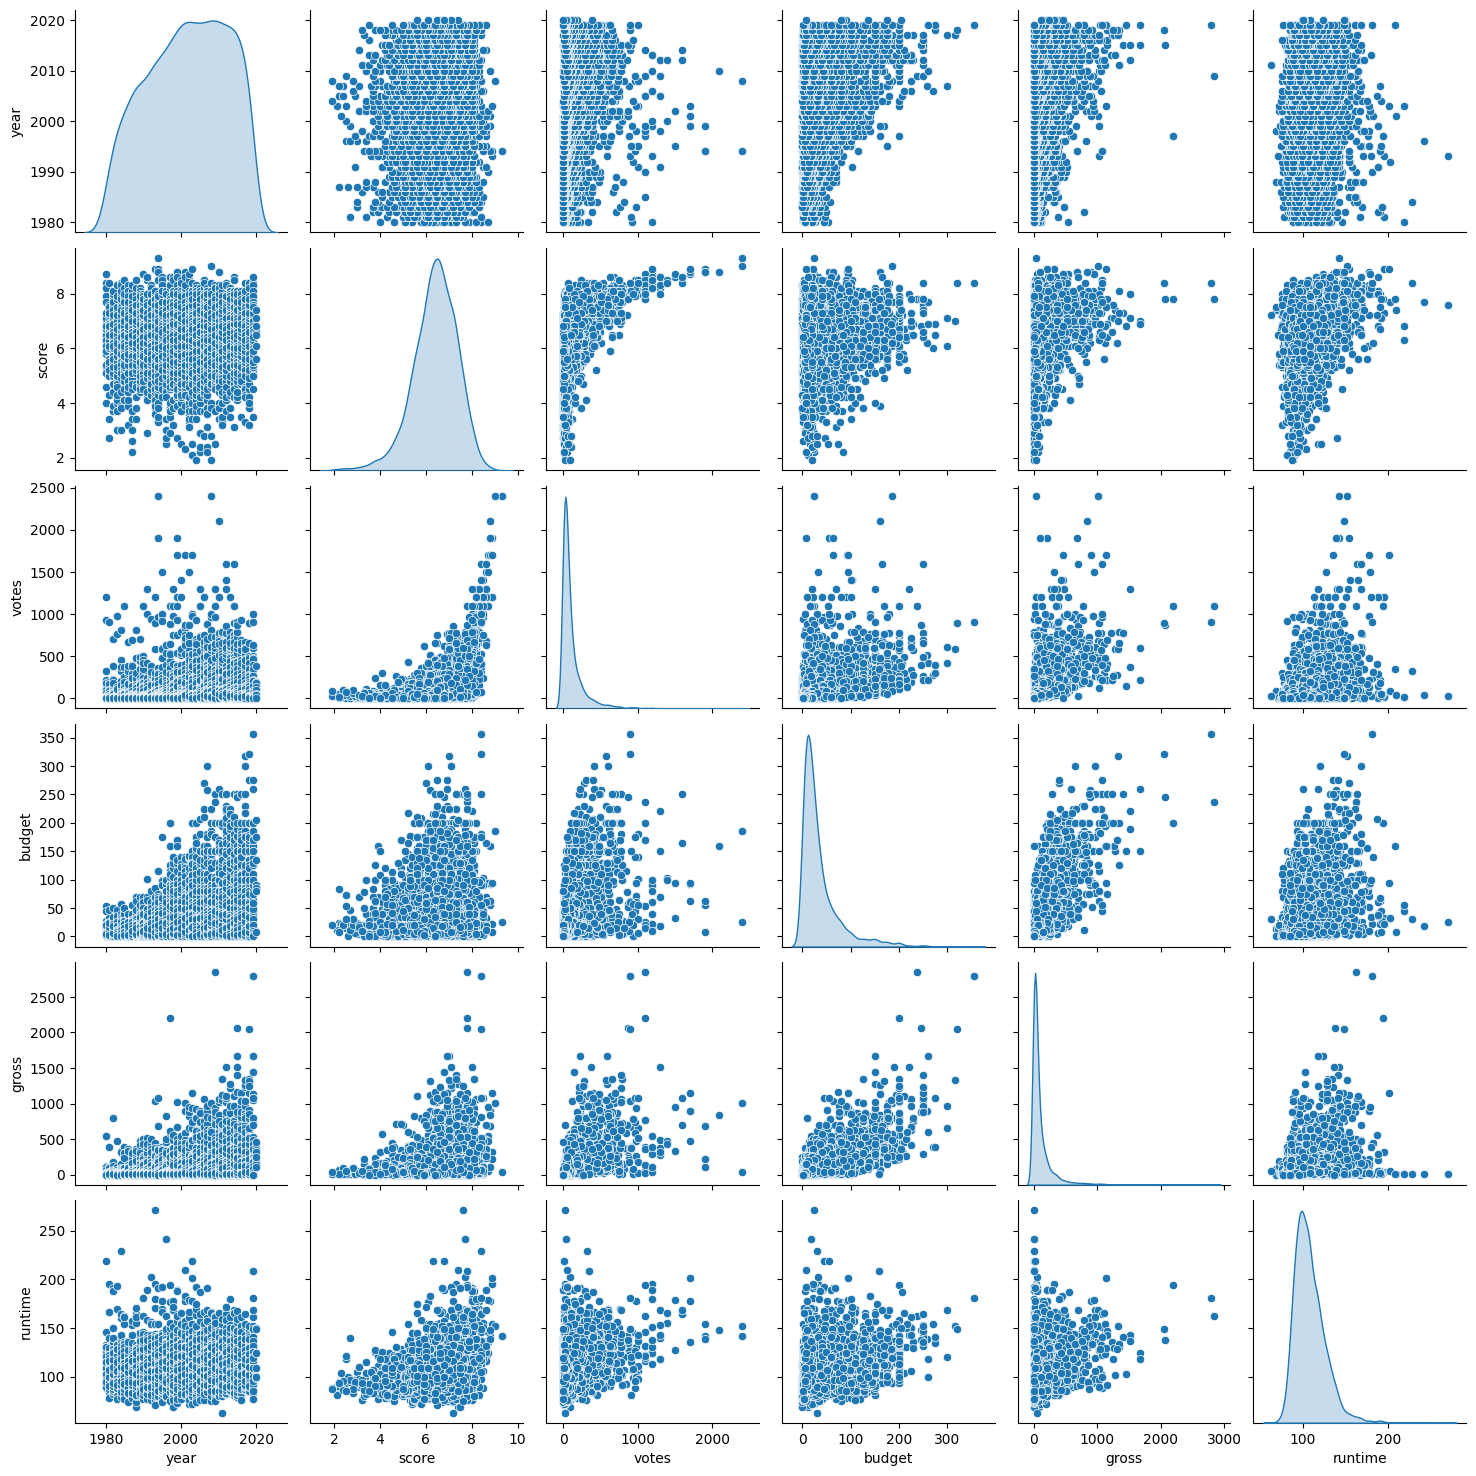

In [128]:
pairplot(data = data, diag_kind = "kde")

In [5]:
lin_model = smf.ols(formula = "gross ~ year + score + votes + budget + runtime", data = train_data)
lin_model = lin_model.fit()
print(lin_model.summary())

lin_model_pared = smf.ols(formula = "gross ~ score + votes + budget + runtime", data = train_data)
lin_model_pared = lin_model_pared.fit()
print(lin_model_pared.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     1676.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:50:55   Log-Likelihood:                -26619.
No. Observations:                4348   AIC:                         5.325e+04
Df Residuals:                    4342   BIC:                         5.329e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -140.7656    338.379     -0.416      0.6

In [6]:
multi_model = smf.ols(formula = "gross ~ year + score + votes + budget + runtime + year*votes + year*budget + year*runtime + score*votes + score * budget + votes*budget", data = train_data)
multi_model = multi_model.fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1071.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:50:58   Log-Likelihood:                -26102.
No. Observations:                4348   AIC:                         5.223e+04
Df Residuals:                    4336   BIC:                         5.230e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4268.6509   1793.801     -2.380   

In [29]:
multi_model_test = smf.ols(formula = "gross ~ year + score + votes + budget + runtime + year*votes + year*budget + year*runtime + score*votes + score * budget + votes*budget", data = test_data)
multi_model_test = multi_model_test.fit()
train_rsquared = multi_model.rsquared_adj
test_rsquared = multi_model_test.rsquared_adj

print(f"Adjusted R squared for train data: {train_rsquared:.2f}")
print(f"Adjusted R squared for  test data: {test_rsquared:.2f}")

def get_avg_error(y, yhat):
    total_err = 0
    n = len(y)
    for i in range(n):
        total_err += abs(y[i] - yhat[i])
    return total_err / n

results_train = multi_model.predict(train_data)
results_train = results_train.to_list()
results_test = multi_model.predict(test_data)
results_test = results_test.to_list()
gross = test_data.get("gross")
gross = gross.to_list()

avg_error_train = get_avg_error(gross, results_train)
avg_error_test = get_avg_error(gross, results_test)
print(f"Average error between prediction on train data and reality: {avg_error_train:.2f} million")
print(f"Average error between prediction on  test data and reality: {avg_error_test:.2f} million")

Adjusted R squared for train data: 0.73
Adjusted R squared for  test data: 0.75
Average error between prediction on train data and reality: 142.07 million
Average error between prediction on  test data and reality: 48.26 million


In [36]:
y = data["gross"].values
x = data.drop("gross", axis=1).values

train_x, test_x, train_y, test_y = train_test_split(x,y,train_size = 0.8, random_state = 0)

def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes =None):
    clf = DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes)
    clf.fit(data_X, data_y)
    return clf


In [37]:
clfs = []
for i in range(1,10):
    clf = build_dt(train_x, train_y, max_depth = i)
    clfs.append(clf)
    predictions = clf.predict(test_x)
    avg_error = get_avg_error(test_y, predictions)
    print(f"Depth {i} test score: {clf.score(test_x, test_y):.2f}, average error: {avg_error:.2f}")

Depth 1 test score: 0.34, average error: 86.14
Depth 2 test score: 0.55, average error: 65.90
Depth 3 test score: 0.58, average error: 61.83
Depth 4 test score: 0.69, average error: 54.61
Depth 5 test score: 0.69, average error: 53.06
Depth 6 test score: 0.67, average error: 52.52
Depth 7 test score: 0.66, average error: 52.65
Depth 8 test score: 0.65, average error: 52.87
Depth 9 test score: 0.64, average error: 54.14


In [56]:
class RandomForest():
    
    def __init__(self, x, y, sample_sz, n_trees=200, n_features='sqrt', max_depth=10, min_samples_leaf=5):
        """
        Create a new random forest regressor.
        
        Args:
            x : Input Feature vector
            y : Corresponding Labels
            sample_sz : Sample size
            n_trees : Number of trees to ensemble
            n_features : Method to select subset of features 
            max_depth : Maximum depth of the trees in the ensemble
            min_sample_leaf : Minimum number of samples per leaf 
        """
        np.random.seed(42)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "sha: ",x.shape[1])  
        self.features_set = []
        self.x, self.y, self.sample_sz, self.max_depth, self.min_samples_leaf  = x, y, sample_sz, max_depth, min_samples_leaf
        self.trees = [self.create_tree(i) for i in range(n_trees)]

    def create_tree(self,i):
        """
        create a single decision tree classifier
        """
        
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        idxs = np.asarray(idxs)

        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        f_idxs = np.asarray(f_idxs)
        
        
        if i==0:
            self.features_set = np.array(f_idxs, ndmin=2)
            #print(self.features_set)
        else:
            self.features_set = np.append(self.features_set, np.array(f_idxs,ndmin=2),axis=0)
        
        # TODO: build a decision tree classifier and train it with x and y that is a subset of data (use idxs and f_idxs)
        
        # your code here
        
        clf = DecisionTreeRegressor(max_depth = self.max_depth, min_samples_leaf = self.min_samples_leaf)        
        x,y = self.x[idxs][:,f_idxs], self.y[idxs]
        clf.fit(x, y)
            
        return clf
       
    def predict(self, x):
        
        # TODO: create a vector of predictions  and return
        # You will have to return the predictions of the final ensembles based on the individual trees' predicitons
        
        # go through every point and average all the predictions
        
        yhat = []
        for point in x:
            predictions = []
            
            for tree_i in range(len(self.trees)):
                features = self.features_set[tree_i]
                limited_point = self.get_features(features, point)
                predictions.append(self.trees[tree_i].predict(limited_point.reshape(1,-1)))
                
            pred = sum(predictions) / len(predictions)
            yhat.append(pred)
        return yhat
    
    def average_error(self, X, y):
        
        # TODO: Compute the average_error using the predict function and true labels y
        
        # your code here
        
        predictions = self.predict(X)
        total_error = 0
        for i in range(len(y)):
            total_error += abs(predictions[i] - y[i])
        return total_error / len(y)
        
                
        return correct / total
        
    def get_features(self, features, x):
        new_x = []
        for feature in features:
            new_x.append(x[feature])
        return np.array(new_x)


In [57]:
rf = RandomForest(train_x, train_y, sample_sz = 21)
average_error = rf.average_error(test_x, test_y)

print(average_error)

2 sha:  5
[71.72102894]
